In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

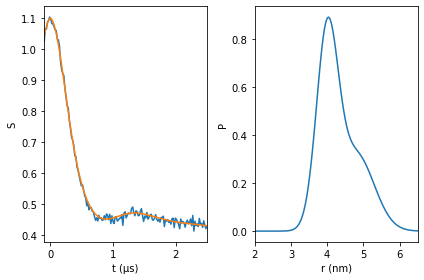

In [2]:
testdata, testpars = dive.generateMultiGauss(nr = 120, nt = 150, seed = 129, r_edges = [2, 6.5])

t = testdata['t']
Vexp = testdata['V']
Ptruth = testdata['P']
r = testdata['r']
Vm = testdata['V0']

Vscale = 1.1
Vexp = Vscale*Vexp
Vm = Vscale*Vm

sigma_model = testpars['sigma']


fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, Vm)
line2 = ax[1].plot(r, Ptruth)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

In [3]:
B = dl.bg_exp(t,0.1)  
lamb = 0.5

S = np.divide(Vexp/Vscale,B)
S = (S-1+lamb)/lamb

In [4]:
r = np.linspace(2,6.5,120)

K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

KtK = np.matmul(np.transpose(K),K)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

a0 = 0.01
b0 = 1e-6

### Setup model

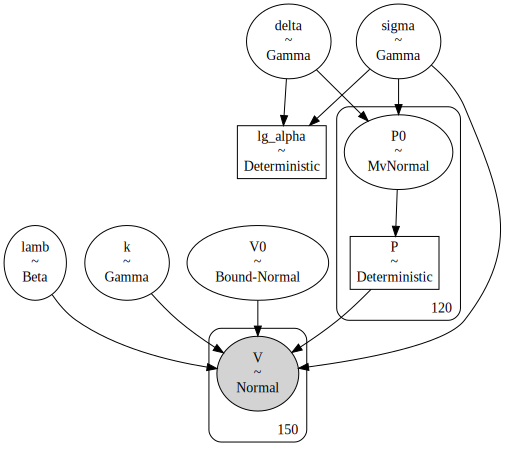

In [5]:
with pm.Model() as model:

    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    delta = pm.Gamma('delta', alpha=a0, beta=b0)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Time Domain
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t,k)         # background decay

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r))    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    Vmodel = V0*(1 -lamb + lamb*pm.math.dot(K,P))*B

    # Likelihood
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

### Run sampler

In [6]:
with model:
    step_P0 = dive.SampleFullP(P0, delta, sigma, k, lamb, V0, LtL, t, Vexp, r)
    trace = pm.sample(step = step_P0, chains=4, cores=4, draws=4000, tune=3000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SampleFullP: [P0]
>NUTS: [k, V0, lamb, delta, sigma]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
Series([], )
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.56642574839269, but should be close to 0.8. Try to increase the number of tuning steps.


ParallelSamplingError: Bad initial energy

In [16]:
dive.summary(trace, model, Vexp, t, r, Pref = testdata['P'])   

ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, TensorConstant{[[-7.97189..3729e-03]]}, P, TensorConstant{0.0})
Toposort index: 14
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(150,), (), (150, 120), (200,), ()]
Inputs strides: [(8,), (), (960, 8), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(0.)]
Outputs clients: [[Elemwise{Composite{Switch(i0, (i1 * ((i2 * i3 * sqr((i4 - (i5 * ((exp((i2 * i6 * i7)) + (i8 * exp((i2 * i6 * i7)) * i9)) - (i10 * exp((i2 * i6 * i7)))))))) + i11)), i12)}}[(0, 9)](Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, TensorConstant{(1,) of 0.5}, TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, TensorConstant{[1.0250039...43053522]}, Elemwise{exp,no_inplace}.0, Elemwise{exp,no_inplace}.0, TensorConstant{[0.1      ...5       ]}, sigmoid.0, CGemv{inplace}.0, sigmoid.0, Elemwise{Composite{log((i0 * i1))}}.0, TensorConstant{(1,) of -inf})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

### Analysis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.142,0.095,0.047,0.238,0.067,0.057,2.0,2.0,4.92
λ,0.446,0.078,0.371,0.519,0.053,0.044,2.0,2.0,4.98
V₀,0.938,0.071,0.869,1.008,0.050,0.042,2.0,2.0,5.17
σ,0.144,0.085,0.067,0.216,0.056,0.046,2.0,2.0,4.67
δ,16624.222,2652.313,14552.810,18653.019,1464.967,1145.249,2.0,2.0,4.86
lg(α),1.192,0.286,0.909,1.470,0.201,0.169,2.0,2.0,4.80


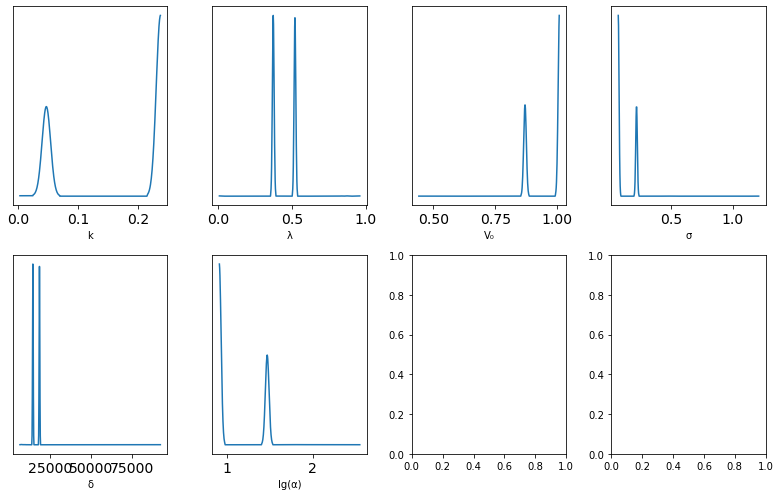

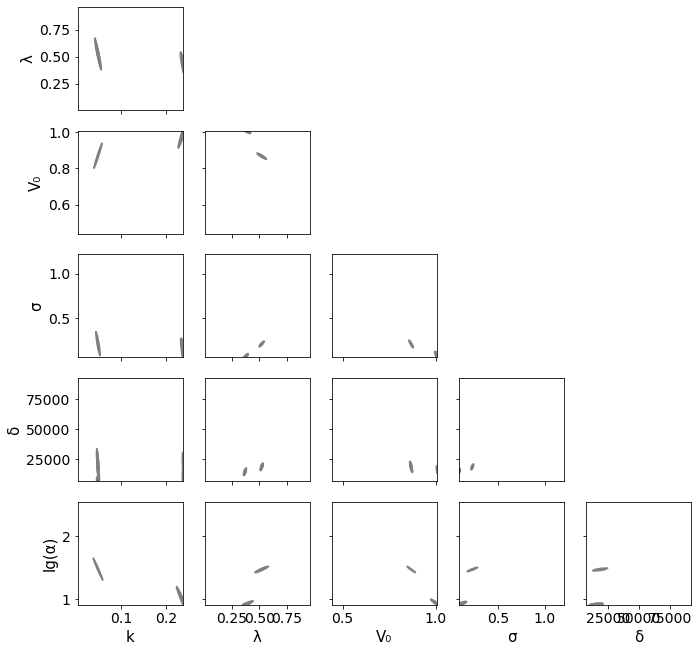

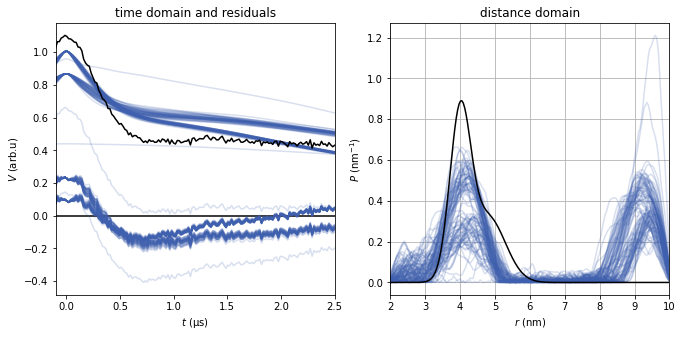

In [26]:
dive.summary(trace, model, Vexp, t, r, Pref = testdata['P'])   